In [2]:
import sys
sys.path.append('../..')

import eeg_decoder 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)
%load_ext autoreload
%autoreload 2

C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

behavior = None
experiment_name = 'e' 
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
    
for isub in range(2,exp.nsub):
    # Load subject's behavior data
    if behavior is None:
        behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','BlockFeature','ACC','RT']]
    else:
        temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','SetSize','BlockFeature','ACC','RT']]
        behavior = behavior.append(temp)

behavior.tail()

,Subject,SetSize,BlockFeature,ACC,RT
1048,19,2,0,1,1666.115479
1049,19,2,0,1,612.309406
1050,19,2,0,1,540.392259
1051,19,0,0,1,275.781465
1052,19,0,0,1,279.534767


In [4]:
behavior = behavior.query('SetSize != 0')
total_means = behavior.groupby(['SetSize','BlockFeature'])['ACC'].mean().reset_index(drop=True)
subject_means = behavior.groupby(['SetSize','BlockFeature','Subject'])['ACC'].mean().reset_index()
subject_means['BlockFeature'] = subject_means['BlockFeature'].map({0:'Color',1:'Motion'})
total_means

0    0.987387
1    0.892586
2    0.975943
3    0.824014
Name: ACC, dtype: float64

In [5]:
subject_means.groupby(['Subject','SetSize','BlockFeature']).mean()

ACC
Subject SetSize BlockFeature          
4       1       Color         1.000000
                Motion        0.888889
        2       Color         1.000000
                Motion        0.899038
5       1       Color         0.967033
                Motion        0.910714
        2       Color         0.930693
                Motion        0.830097
6       1       Color         1.000000
                Motion        0.938182
        2       Color         1.000000
                Motion        0.831461
7       1       Color         0.978814
                Motion        0.950207
        2       Color         0.991632
                Motion        0.903226
8       1       Color         0.983871
                Motion        0.904762
        2       Color         0.979592
                Motion        0.858369
10      1       Color         0.991561
                Motion        0.960159
        2       Color         0.991561
                Motion        0.890688
11      1       Color         0.986486
                Motion        0.890295
        2       Color         0.991189
                Motion        0.829596
13      1       Color         1.000000
                Motion        0.725000
        2       Color         0.962733
                Motion        0.609589
14      1       Color         0.957895
                Motion        0.921951
        2       Color         0.858639
                Motion        0.828431
15      1       Color         0.986111
                Motion        0.780488
        2       Color         0.990950
                Motion        0.674877
16      1       Color         0.995516
                Motion        0.971264
        2       Color         0.995349
                Motion        0.937198
18      1       Color         1.000000
                Motion        0.965753
        2       Color         1.000000
                Motion        0.839744
19      1       Color         0.987500
                Motion        0.770213
        2       Color         0.975709
                Motion        0.702479

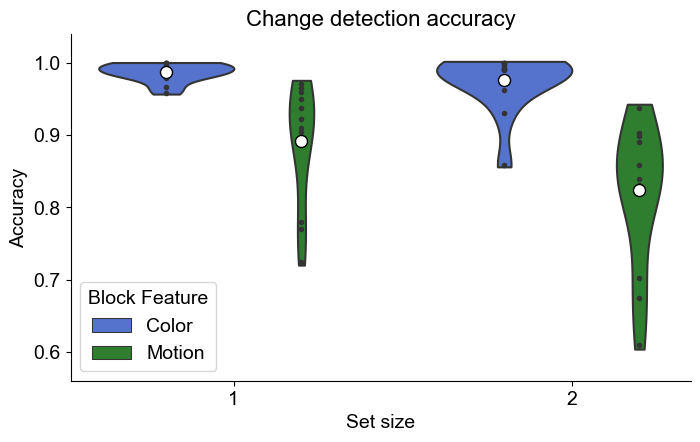

In [26]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,4.5))
my_pal = {"royalblue", "forestgreen"}

# experiment 1
sns.violinplot(
    ax = ax,
    x = 'SetSize',
    y = 'ACC',
    hue = 'BlockFeature',
    data = subject_means,
    dodge=True,
    inner='points',
    palette=my_pal,
    cut=.1
)
ax = plt.gca()
# plot means
ax.scatter(
    x = [-.2,.2,.8,1.2],
    y = [total_means[0],total_means[1],total_means[2],total_means[3]],
    c = 'white', edgecolors='k',s=75)

# asethetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Set size',fontsize=14)
ax.set_ylabel('Accuracy',fontsize=14)
ax.set_title('Change detection accuracy',fontsize=16)
plt.legend(loc='lower left',fontsize=14,title_fontsize=14)
leg = ax.get_legend()
leg.set_title(title='Block Feature')
plt.ylim([.56,1.04])
plt.savefig('output/figures/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500,bbox_inches='tight')

plt.show()

# Accuracy ANOVA within each experiment

In [11]:
subject_means = subject_means.rename({'BlockFeature':'Feature'},axis=1)

In [12]:
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(subject_means, 'ACC', 'Subject', within=['Feature','SetSize'],aggregate_func='mean')
res = aovrm.fit()
print(res)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Feature         26.0175 1.0000 12.0000 0.0003
SetSize         31.4743 1.0000 12.0000 0.0001
Feature:SetSize 27.7626 1.0000 12.0000 0.0002

